In [112]:
import os
import contextlib
import io
import getpass
from dotenv import load_dotenv
from enum import Enum
import os
from rich.markdown import Markdown
from rich import print as md
from langchain.output_parsers import PydanticOutputParser
load_dotenv()
from langchain_openai.chat_models import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from typing import Annotated, List, Sequence, Tuple, TypedDict, Union
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
import operator
from langchain_core.agents import AgentFinish
from langgraph.prebuilt.tool_executor import ToolExecutor
from langgraph.graph import END, StateGraph
import json

from langchain_core.messages import (
    AIMessage,
    BaseMessage,
    ChatMessage,
    FunctionMessage,
    HumanMessage,
)
from langchain.tools.render import format_tool_to_openai_function
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph
from langgraph.prebuilt.tool_executor import ToolExecutor, ToolInvocation
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from pydantic import BaseModel, Field, validator
from Models.models import LLMModel



#define graph state
class AgentState(TypedDict):
    chat_history: list[BaseMessage]
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str
    user_config:dict




class Code(BaseModel):
    code: str = Field(description=" complete code to be executed")


class Severity(Enum):
    CRITICAL = "Critical"
    MEDIUM = "Medium"
    LOW = "Low"

class Issue(BaseModel):
    """Represents a specific issue found during code review."""

    cell_position: int = Field(
        ..., description="The position of the cell where the issue was found."
    )
    what: str = Field(..., description="A brief description of the issue.")
    why: str = Field(..., description="Explanation of why this is an issue.")
    where: str = Field(
        ...,
        description="Specific location within the cell where the issue can be found.",
    )
    severity: Severity = Field(
        ...,
        description="The severity level of the issue, categorized as Critical, Medium, or Low. Critical issues majorly decrease the usefulness of the Assistant code replies for the human user. Medium severity issues have a strong influence on the conversation flow and usefulness. Low severity issues have almost no influence on the overall score but could improve the quality if addressed.",
    )
    fix: str = Field(
        ..., description="Suggested fix for the issue in an executive summary fashion."
    )


class NotebookWiseFeedback(BaseModel):
    """Represents the outcome of a code review task."""

    scratchpad: str = Field(
        ...,
        description="Place for you to think. Think before issues and score creation. Be concise. Analyze the text to achieve your goal. Always think before looking for issues!",
    )
    issues: list[Issue] = Field(
        ...,
        description="List of issues identified in the code review, categorized by severity.",
    )
    scoring_explanation: str = Field(
        ...,
        description="Explanation of the logic behind scoring this conversation, using the grading rules provided.",
    )
    score: int | None = Field(
        ...,
        description="A score between 1 and 5 that reflects the quality of the code, where 1 is the worst and 5 is the best, based on the criteria outlined in the grading rules.",
    )



class TestResult(Enum):
    PASSED = "Passed"
    FAILED = "Failed"

class TestResults(BaseModel):
    """Represents the outcome of a test."""
    result: str = Field(
        ..., description="The result of the test, either PASSED or FAILED."
    )
    comment: str = Field(
        ..., description="Any comments or notes about the test result."
    )




    
#Nodes Output schema
class StandardResponse(BaseModel):
    """Represents a standard response from the agent/ai."""
    response: str = Field(description="your actual response/answer in markdown format")
    sender: str = Field(description="your name in lowercase")
    directed_to: str = Field(description="your response must be directed to another agent or to human")
    
    
    
#Testers Output schema
class Issues(BaseModel):
    """Represents a list of potential issues."""
    issues: List[Issue] = Field(description="List of potential issues")


class HappyPaths(BaseModel):
    """Represents a list of happy paths."""
    happy_paths: List[str] = Field(description="List of happy paths")
    code: str = Field(description="The original code given to you")

class EdgeCases(BaseModel):
    """Represents a list of edge cases."""
    edge_cases: List[str] = Field(description="List of edge cases")
    
#Base Prompt Template   
def get_base_prompt_template(name=None, custom_instructions=None, agents=None):
    prompt_template = ChatPromptTemplate.from_messages(
    [
    (
    "system",
    "Your name is {name} and you are working along side other agents as listed below "
    "Agents: \n {agents} "
    "{custom_instructions} "
    ""
    )
    ]
    )
    
    prompt_template = prompt_template.partial(name=name)
    prompt_template = prompt_template.partial(agents=agents)
    prompt_template = prompt_template.partial(custom_instructions=custom_instructions if custom_instructions else "")
    return prompt_template

#Notebook loader
import nbformat
def load_notebook(path):
    with open(path) as f:
        nb = nbformat.read(f, as_version=4)
    return nb


#### TOOLS




In [113]:
@tool
def python_repl(code: Annotated[str, "The python code to execute."]):
    """Use this to execute python code when needed. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user and you.
    """
    # Create StringIO objects to capture stdout and stderr
    stdout = io.StringIO()
    stderr = io.StringIO()

    # Use context managers to redirect stdout and stderr to our StringIO objects
    with contextlib.redirect_stdout(stdout), contextlib.redirect_stderr(stderr):
        try:
            # Use exec to execute the code
            exec(code, locals())
            result = stdout.getvalue()
            error = stderr.getvalue()
        except Exception as e:
            # If an error occurs during execution, return the error message
            return f"Failed to execute. Error: {repr(e)}"

    # If no errors occurred, return the output
    if error:
        return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}\nStderr: {error}"
    else:
        return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"



@tool
def write_file(name: Annotated[str, "The name of the file."], content: Annotated[str, "The content of the file."]):
    """This tool writes a file with the given name and content to the Playground directory."""
    # Define the directory
    directory = "Playground"
    
    # Create the directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # Define the file path
    file_path = os.path.join(directory, name)
    
    # Write the content to the file
    try:
        with open(file_path, 'w') as file:
            file.write(content)
        status = "File created successfully"
    except Exception as e:
        status = f"Failed to create file. Error: {repr(e)}"
    
    # Return the name and status of creation
    return {"full_path": file_path, "status": status}

@tool
def run_js_code(js_code: Annotated[str, "The JavaScript code to run."]):
    """This tool runs the provided JavaScript code and returns the result."""
    # Use execjs to execute the JavaScript code
    ctx = execjs.compile(js_code)

    # Get the result of the JavaScript code
    result = ctx.eval('result')

    # Return the result
    return {"result": result}


all_tools = [
            python_repl,
            write_file,
            run_js_code
        ]

#### CODE EXTRACTOR

In [114]:

code_extractor_prompt_template = get_base_prompt_template(
    name="code_extractor",
    custom_instructions="Your role is to extract the code provided by the AI assistant from the conversation in the notebook. "
                        "Once you've extracted the code, forward it to the agent named testers without making any changes. ",
    agents="testers"
)

code_extractor = LLMModel(
    provider="openai_api",
    model="gpt-4o",
    use_history=False,
    #use_tool=False,
    output_schema=StandardResponse.model_json_schema(),
    prompt_template=code_extractor_prompt_template
)



#### HAPPY_PATH AND EDGE_CASE

In [115]:

# Happy Pather Agent
happy_pather_prompt_template = get_base_prompt_template(
    name="happy_pather aka testers",
    custom_instructions="Your role is to generate and list  happy path  test cases that should be tested (not test code). "
                        "Once you've created the test cases, share them with another agent called codia. ",
    agents="codia"
)

happy_pather = LLMModel(
    provider="openai_api",
    model="gpt-4o",
    use_history=False,
    #use_tool=False,
    output_schema=HappyPaths.model_json_schema(),
    prompt_template=happy_pather_prompt_template
)

# Edge Caser Agent
edge_caser_prompt_template = get_base_prompt_template(
    name="edge_caser aka testers",
    custom_instructions="Your role is to generate and list edge case test cases that should be tested (not test code) for the provided code. "
                        "Once you've created the test cases, share them with another agent called codia. ",
                      
    agents="codia"
)

edge_caser = LLMModel(
    provider="openai_api",
    model="gpt-4o",
    use_history=False,
    #use_tool=False,
    output_schema=EdgeCases.model_json_schema(),
    prompt_template=edge_caser_prompt_template
)



### ISSUE FINDER, ISSUE VERIFFER and TESTER NODE

In [116]:

# Issue Finder Agent
issue_finder_prompt_template = get_base_prompt_template(
    name="issue_finder",
    custom_instructions="Your role is to identify and list issues with the provided code. "
                        "Once you've identified the issues, share them with another agent called issue_verify. ",
    agents="issue_verify"
)

issue_finder = LLMModel(
    provider="openai_api",
    model="gpt-4o",
    use_history=False,
    #use_tool=False,
    output_schema=Issues.model_json_schema(),
    prompt_template=issue_finder_prompt_template
)



#### CODIA

In [117]:
codia_prompt_template = get_base_prompt_template(
    name="codia",
    custom_instructions="Think step by step:"
                        "1. You will receive a list of happy path test cases and edge cases."
                        "2. Your job is to generate a function to test each of the provided cases."
                        "3. Share the generated function with code_checker."
                        "4. The aim is not to improve the original code but to test it."
                        "5. code_checker can either ask you to make an adjustment to the code to make it safe or more efficient if not the user will execute the code using a function called_ and show you the results."
                        "6. When code_checker asks for adjustments, make the necessary adjustments and show her, do this until she informs you she/he is satisfied with the code and has executed it. At this point, you will be shown the results of the execution."
                        "7. Ensure you use the print function within your code to get more feedback."
                        "8. Take note that the functions have to be defined (stand alone executed code) within the code to be executed successfully."
                        "9. Finally, you can gather all observations and generate your final evaluation results."
                        "10. I REPEAT, always forward a complete code to code_checker that can be executed as a stand alone code."
                        "ONCE YOU HAVE YOUR FINAL EVALUATION, PROVIDE IT IN DETAILS AND ENSURE YOU DIRECT IT TO the 'eval_merger' agent",
    agents="code_checker and eval_merger"
)

codia = LLMModel(
    provider="openai_api",
    model="gpt-4o",
    use_tool=True,
    use_history=False,
    output_schema=StandardResponse,
    prompt_template=codia_prompt_template
)



#### CODIA CODE REFLECTOR AND RUNNER

In [118]:
code_checker_prompt_template = get_base_prompt_template(
    name="code_checker",
    custom_instructions="You a professional python developer with years of experience in programming called code_checker."
                        "You are working along side other agents [codia and code_runner]"
                        "The codia will provide code which is meant to be tests for a function, your job is simple: "
                        "First you must say if the code is safe to run on a machine, and also suggest why and the corrections to make it safe"
                        "Lastly also suggest betters ways to write the code if needed for better performance."
                        "if You are ok with the code after some few iterations, go ahead and forward the entire code to code_runner who will then run the code and provide you with results"
                        "Finally, you can forward that result from code_runner back to codia",
    agents="codia and code_runner"
)

code_checker = LLMModel(
    provider="openai_api",
    model="gpt-4o",
    use_tool=True,
    use_history=False,
    output_schema=StandardResponse,
    prompt_template=code_checker_prompt_template
)



code_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "As a seasoned Python and JavaScript developer, you are known as code_runner. Your role involves the following steps:"
            "1. You will be given a piece of code along with a test scenario, which could be a happy path or an edge case."
            "2. Your task is to write the test code and combine it with the original code to form a complete script."
            "3. If the test requires dummy files such as JSON or CSV, use the write_file function to create them."
            "4. Execute the complete code and test using the python_repl function. This approach eliminates the need for any unit test framework."
            "5. If you encounter any issues after invoking any function, feel free to make necessary corrections and retry."
            "Remember, always write a complete code that can be executed as a standalone script. Do not modify the original code being tested."
            "NOTE: Use the print function to output information for better observation and debugging."
            "NOTE: Avoid using 'if __name__ == '__main__' as this will prevent the code from running."
            "Finally, report if the test passed and any other comment you have using this schema:\n {schema} and nothing else"
            
            

            
        ),
        MessagesPlaceholder(variable_name="messages")
    ])

parser = PydanticOutputParser(pydantic_object=TestResults)
standard_test = parser.get_format_instructions()
code_prompt = code_prompt.partial(schema = standard_test )
llm3 = ChatOpenAI(model="gpt-4o", 
                  # model_kwargs = {"response_format":{"type": "json_object"}}
                 )
functions = [format_tool_to_openai_function(t) for t in all_tools]
model3 = code_prompt | llm3.bind_functions(functions)

def code_runner(state):
    print("\n\n--- INPUT_TO_CODE:", state, "----\n\n")
    out = model3.invoke(state)
    if "function_call" in out.additional_kwargs:
        message = [AIMessage(content=out.content, additional_kwargs=out.additional_kwargs)]
    else:
        message = [AIMessage(content=out.content)]
    #print("TYPE:", out)
    
    return {
        "messages":message,
        "sender": "code_runner",
    }




#Tool Executor
tool_executor = ToolExecutor(all_tools)
def tool_node(state):

    """This runs tools in the graph

    It takes in an agent action and calls that tool and returns the result."""
    messages = state["messages"]
  
    # Based on the continue condition
    # we know the last message involves a function call
    last_message = messages[-1]
    # We construct an ToolInvocation from the function_call
    try:
        tool_input = json.loads(
            last_message.additional_kwargs["function_call"]["arguments"]
        )
    except:
        tool_input = {"code":last_message.additional_kwargs["function_call"]["arguments"]} #sometimes the actual code is sent as a string instead of {code:"code"}
    # We can pass single-arg inputs by value
    if len(tool_input) == 1 and "__arg1" in tool_input:
        tool_input = next(iter(tool_input.values()))
    tool_name = last_message.additional_kwargs["function_call"]["name"]
    action = ToolInvocation(
        tool=tool_name,
        tool_input=tool_input,
    )
    # We call the tool_executor and get back a response
    response = tool_executor.invoke(action)
    # We use the response to create a FunctionMessage
    function_message = FunctionMessage(
        content=f"{tool_name} response: {str(response)}", name=action.tool
    )
    # We return a list, because this will get added to the existing list
    return {"messages": [function_message]}
        


#### MERGER

In [119]:

eval_merger_prompt_template = get_base_prompt_template(
    name="eval_merger",
    custom_instructions="You are a professional python developer with years of experience in programming, known as eval_merger."
                        "You are working alongside two other agents: issue_finder and codia."
                        "The issue_finder will provide a list of issues found in the code, and codia will provide the code which is meant to be tests for a function."
                        "Your job is to evaluate the code based on the issues found and the code provided."
                        "First, you must evaluate if the code is safe to run on a machine, and also suggest why and the corrections to make it safe."
                        "Lastly, also suggest better ways to write the code if needed for better performance."
                        "After evaluating the code and the issues found, provide a final evaluation of the code.",
)
eval_merger = LLMModel(
    provider="openai_api",
    model="gpt-4o",
    use_tool=True,
    use_history=False,
    output_schema=NotebookWiseFeedback,
    prompt_template=eval_merger_prompt_template 
)


#### NODES

In [120]:
def code_extractor_node(state):
    x =  HumanMessage(json.dumps(code_extractor(state)))
    return {
        "messages": [x],
        "sender": "code_extractor",
    }

def happy_pather_node(state):
    x = HumanMessage(json.dumps(happy_pather(state)))
    return {
        "messages": [x],
        "sender": "happy_pather",
    }

def edge_caser_node(state):
    x = HumanMessage(json.dumps(edge_caser(state)))
    return {
        "messages": [x],
        "sender": "edge_caser",
    }

def issue_finder_node(state):
    x = HumanMessage(json.dumps(issue_finder(state)))
    return {
        "messages": [x],
        "sender": "issue_finder",
    }

def codia_node(state):
    x = HumanMessage(json.dumps(codia(state)))
    return {
        "messages": [x],
        "sender": "codia",
    }

def code_checker_node(state):
    x = HumanMessage(json.dumps(code_checker(state)))
    return {
        "messages": [x],
        "sender": "code_checker",
    }

code_runner_node = code_runner
   

def eval_merger_node(state):
    x = HumanMessage(json.dumps(eval_merger(state)))
    return {
        "messages": [x],
        "sender": "eval_merger",
    }
    
def combine_tests_node(state):
    import copy
    testers_input = copy.deepcopy(state["messages"])
    happy_output = happy_pather(testers_input)
    edge_output = edge_caser(testers_input)
    issues = issue_finder(testers_input)
    combined_output = {"happy":happy_output['happy_paths'], "edge":edge_output['edge_cases'], "issues":issues['issues'], "code":happy_output["code"]}
    return {
        "messages": [HumanMessage(json.dumps(combined_output))],
        "sender": "testers",
    }
    

    
tool_node = tool_node




In [121]:
def draw(graph):
    #DRAW GRAPH
    from langchain_core.runnables.graph import CurveStyle, NodeColors, MermaidDrawMethod
    from IPython.display import display, HTML, Image

    display(
        Image(
            graph.get_graph().draw_mermaid_png(
                draw_method=MermaidDrawMethod.API,
            )
        )
    )

#### GRAPH

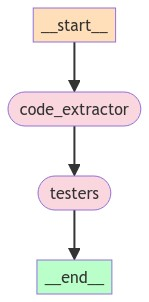

In [122]:
workflow1 = StateGraph(AgentState)
workflow1.add_node("code_extractor", code_extractor_node)
workflow1.add_node("testers",combine_tests_node)


workflow1.add_edge("code_extractor", "testers")
workflow1.add_edge("testers", END)

workflow1.set_entry_point("code_extractor")
graph1 = workflow1.compile()


draw(graph1)

def testers_graph(notebook, graph=graph1):
    messages_in = messages_in = [HumanMessage(content="Here is the conversation {}".format(notebook))]
    input_message = {
    "chat_history": [],
    "messages": messages_in,
    "user_config": {},
    }


    for s in graph.stream(input_message, {"recursion_limit": 20}):
        print("AGENT:", s)
        agent = list(s.keys())[0]
        content = s[agent]["messages"][-1].content
        if agent == "testers":
            h = json.loads(content)
            tests_content = f"Happy: {h['happy']}\n\nEdge: {h['edge']}\n\nIssues: {h['issues']}"
            tests_content = Markdown(tests_content)
            md(tests_content)
        elif agent != "tool_node":
            #check if it is trying to call a function/tool
            if "function_call" in s[agent]["messages"][-1].additional_kwargs:
                function_being_called = s[agent]["messages"][-1].additional_kwargs['function_call']['name']
                args = s[agent]["messages"][-1].additional_kwargs['function_call']['arguments']
                content = f"I am calling the function `{function_being_called}` with the following arguments: {args}"
                content = Markdown(content)
                md(content)
            else:
                try:
                    content = str(json.loads(content)["response"])
                except:
                    pass
                content = Markdown(content)
                md(content)
        else:
            content = Markdown(content)
            md(content)
            
            
    return h



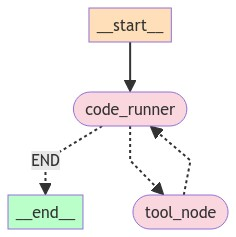

In [123]:

def router(state):
    # This is the router
    messages = state["messages"]
    sender = state["sender"]
    last_message = messages[-1]
    
    if "function_call" in last_message.additional_kwargs:
        return "tool_node" #irrespective of the sender
    else: return "END"
    
 
workflow2 = StateGraph(AgentState)

workflow2.add_node("code_runner", code_runner)
workflow2.add_node("tool_node",  tool_node)
workflow2.add_conditional_edges(
        "code_runner",
        router,
        { "END": END, "tool_node": "tool_node"},
    )
workflow2.add_conditional_edges(
        "tool_node",
        lambda x: x["sender"],
        {"code_runner":"code_runner"},
    )

workflow2.set_entry_point("code_runner",)
graph2 = workflow2.compile()


draw(graph2)


def code_runner_graph(test, code):
    messages_in = [HumanMessage(content=
                                "HERE IS THE CODE:\n\n ```{code}``` \n\n  INSTRUCTIONS:\n\n Write the test code to test for this \n {test}".format(code = code, test =test))]
    print(messages_in[0].content)

    input_message = {
        "chat_history": [],
        "messages": messages_in,
        "user_config": {},
    }


    for s in graph2.stream(input_message, {"recursion_limit": 20}):
        print("AGENT:", s)
        agent = list(s.keys())[0]
        content = s[agent]["messages"][-1].content
        if agent != "tool_node":
            #check if it is trying to call a function/tool
            if "function_call" in s[agent]["messages"][-1].additional_kwargs:
                function_being_called = s[agent]["messages"][-1].additional_kwargs['function_call']['name']
                args = s[agent]["messages"][-1].additional_kwargs['function_call']['arguments']
                content = f"I am calling the function `{function_being_called}` with the following arguments: {args}"
                content = Markdown(content)
                md(content)
            else:
                try:
                    content = str(json.loads(content)["response"])
                except:
                    pass
                content = Markdown(content)
                md(content)
        else:
            content = Markdown(content)
            md(content)
            
    return s[agent]["messages"][-1].content


In [124]:
notebook = load_notebook("/Users/daniel/Desktop/Projects/TURING/Turing_Evaluator/Data/new_chirag/algorithm_problems_using_python__9__19_03_2024_05_12_22_1.ipynb")

test_cases = testers_graph(notebook)

happy_paths = test_cases["happy"]
code = test_cases["code"]
final_results = []

AGENT: {'code_extractor': {'messages': [HumanMessage(content='{"response": "```python\\nimport numpy as np\\n\\ndef grading_curve(target_mean, scores, target_std=None):\\n\\n    try:\\n        if not isinstance(target_mean, (int, float)):\\n            raise TypeError(\\"Target mean must be a numeric value.\\")\\n\\n        if not isinstance(scores, (list, np.ndarray)):\\n            raise TypeError(\\"Scores must be an array-like object.\\")\\n\\n        if not np.all(isinstance(score, (int, float)) for score in scores):\\n            raise ValueError(\\"Scores must contain only numeric values.\\")\\n\\n        if len(scores) == 0:\\n            raise ValueError(\\"Scores cannot be empty.\\")\\n\\n        # Calculate the original mean and standard deviation\\n        scores_mean, scores_std = np.mean(scores), np.std(scores, ddof=1)\\n\\n        # Calculate adjustment and scaling factors\\n        adjustment = target_mean - scores_mean  # Adjust for target mean difference\\n        sca

                                                                                                                   
 import numpy as np                                                                                                
                                                                                                                   
 def grading_curve(target_mean, scores, target_std=None):                                                          
                                                                                                                   
     try:                                                                                                          
         if not isinstance(target_mean, (int, float)):                                                             
             raise TypeError("Target mean must be a numeric value.")                                               
                                                                                                                   
         if not isinstance(scores, (list, np.ndarray)):                                                            
             raise TypeError("Scores must be an array-like object.")                                               
                                                                                                                   
         if not np.all(isinstance(score, (int, float)) for score in scores):                                       
             raise ValueError("Scores must contain only numeric values.")                                          
                                                                                                                   
         if len(scores) == 0:                                                                                      
             raise ValueError("Scores cannot be empty.")                                                           
                                                                                                                   
         # Calculate the original mean and standard deviation                                                      
         scores_mean, scores_std = np.mean(scores), np.std(scores, ddof=1)                                         
                                                                                                                   
         # Calculate adjustment and scaling factors                                                                
         adjustment = target_mean - scores_mean  # Adjust for target mean difference                               
         scale_scores = target_std / scores_std if target_std else 1  # Scale based on target std (or keep origina 
                                                                                                                   
         # Apply curve and clip scores to a valid range                                                            
         curved_scores = scores * scale_scores + adjustment                                                        
         curved_scores = np.clip(curved_scores, 0, 100)                                                            
                                                                                                                   
         return curved_scores  # Return the curved grades                                                          
                                                                                                                   
     except TypeError as te:                                                                                       
         print(f"TypeError: {te}")                                                                                 
         return None                                                                                               
     except ValueError[0

AGENT: {'testers': {'messages': [HumanMessage(content='{"happy": ["Test with valid target mean and scores array", "Test with valid target mean, scores array and target standard deviation", "Test with scores array containing edge values", "Test with target mean and empty scores array", "Test with target mean and scores array containing non-numeric values"], "edge": ["Empty list of scores.", "Scores contain non-numeric values such as strings or None.", "Target mean is not a numeric value.", "Scores list contains a single value.", "Scores list contains negative values.", "All scores in the list are the same.", "Target standard deviation is zero.", "Target standard deviation is negative.", "Original standard deviation is zero (all scores are the same).", "Scores contain very large and very small values."], "issues": [{"cell_position": 5, "what": "Incorrect type check for scores", "why": "The type check for each score element in scores is performed incorrectly. np.all() is used improperly h

Happy: ['Test with valid target mean and scores array', 'Test with valid target mean, scores array and target      
standard deviation', 'Test with scores array containing edge values', 'Test with target mean and empty scores      
array', 'Test with target mean and scores array containing non-numeric values']                                    

Edge: ['Empty list of scores.', 'Scores contain non-numeric values such as strings or None.', 'Target mean is not a
numeric value.', 'Scores list contains a single value.', 'Scores list contains negative values.', 'All scores in   
the list are the same.', 'Target standard deviation is zero.', 'Target standard deviation is negative.', 'Original 
standard deviation is zero (all scores are the same).', 'Scores contain very large and very small values.']        

Issues: [{'cell_position': 5, 'what': 'Incorrect type check for scores', 'why': 'The type check for each score     
element in scores is performed incorrectly. np.all() is used improperly here, leading to a ValueError.', 'where':  
'line: if not np.all(isinstance(score, (int, float)) for score in scores):', 'severity': 'Critical', 'fix':        
'Replace the line with: if not all(isinstance(score, (int, float)) for score in scores):'}, {'cell_position': 5,   
'what': 'Improper handling of target_std equals zero', 'why': 'When target_std is zero, the function will scale    
scores by zero, which is not meaningful and leads to all scores being the same. Zero standard deviation should     
either raise an error or be handled differently.', 'where': 'line: scale_scores = target_std / scores_std if       
target_std else 1', 'severity': 'Medium', 'fix': 'Add a check to raise a ValueError if target_std is zero.'},      
{'cell_position': 5, 'what': 'Function does not handle target_std less than zero', 'why': 'A negative target_std is
not meaningful and should raise an error, but the current implementation does not handle it.', 'where': 'line:     
scale_scores = target_std / scores_std if target_std else 1', 'severity': 'Medium', 'fix': 'Add a check to raise a 
ValueError if target_std is less than zero.'}, {'cell_position': 5, 'what': 'Inconsistent handling of exceptions', 
'why': 'The function prints error messages and returns None, which is inconsistent and not ideal for debugging or  
handling errors programmatically.', 'where': 'lines: except TypeError as te: print(f"TypeError: {te}") return None 
except ValueError as ve: print(f"ValueError: {ve}") return None', 'severity': 'Low', 'fix': 'Consider using logging
for errors or re-raising exceptions after logging them.'}, {'cell_position': 5, 'what': 'Overly broad exception    
handling', 'why': 'Catching all TypeError and ValueError exceptions can mask other issues and makes debugging      
difficult.', 'where': 'lines: except TypeError as te: print(f"TypeError: {te}") return None except ValueError as   
ve: print(f"ValueError: {ve}") return None', 'severity': 'Low', 'fix': 'Catch more specific exceptions related to  
the exact lines where errors can occur.'}]

In [125]:
happy_paths[0]

'Test with valid target mean and scores array'

In [126]:
for i,t  in enumerate(happy_paths):
    final_results.append(code_runner_graph(t, code))


HERE IS THE CODE:

 ``````python
import numpy as np

def grading_curve(target_mean, scores, target_std=None):

    try:
        if not isinstance(target_mean, (int, float)):
            raise TypeError("Target mean must be a numeric value.")

        if not isinstance(scores, (list, np.ndarray)):
            raise TypeError("Scores must be an array-like object.")

        if not np.all(isinstance(score, (int, float)) for score in scores):
            raise ValueError("Scores must contain only numeric values.")

        if len(scores) == 0:
            raise ValueError("Scores cannot be empty.")

        # Calculate the original mean and standard deviation
        scores_mean, scores_std = np.mean(scores), np.std(scores, ddof=1)

        # Calculate adjustment and scaling factors
        adjustment = target_mean - scores_mean  # Adjust for target mean difference
        scale_scores = target_std / scores_std if target_std else 1  # Scale based on target std (or keep original)

        #

I am calling the function python_repl with the following arguments: { "code": "import numpy as np\n\ndef           
grading_curve(target_mean, scores, target_std=None):\n    try:\n        if not isinstance(target_mean, (int,       
float)):\n            raise TypeError("Target mean must be a numeric value.")\n        \n        if not            
isinstance(scores, (list, np.ndarray)):\n            raise TypeError("Scores must be an array-like object.")\n     
\n        if not np.all(isinstance(score, (int, float)) for score in scores):\n            raise ValueError("Scores
must contain only numeric values.")\n        \n        if len(scores) == 0:\n            raise ValueError("Scores  
cannot be empty.")\n        \n        # Calculate the original mean and standard deviation\n        scores_mean,   
scores_std = np.mean(scores), np.std(scores, ddof=1)\n        \n        # Calculate adjustment and scaling         
factors\n        adjustment = target_mean - scores_mean  # Adjust for target mean difference\n        scale_scores 
= target_std / scores_std if target_std else 1  # Scale based on target std (or keep original)\n        \n        #
Apply curve and clip scores to a valid range\n        curved_scores = scores * scale_scores + adjustment\n         
curved_scores = np.clip(curved_scores, 0, 100)\n        \n        return curved_scores  # Return the curved        
grades\n    \n    except TypeError as te:\n        print(f"TypeError: {te}")\n        return None\n    except      
ValueError as ve:\n        print(f"ValueError: {ve}")\n        return None\n\n# Test code\n# Sample scores\nscores 
= np.array([70, 85, 60, 90, 80])\n\n# Target mean (can be adjusted as needed)\ntarget_mean = 75\n\n# Optional      
target standard deviation (default is None, keeping original std)\ntarget_std = 10  # Setting a desired            
value\n\ncurved_scores = grading_curve(target_mean, scores, target_std)\n\nprint(f"Original scores:                
{scores}")\nprint(f"Curved scores: {curved_scores}")\n\n# Check if the test passed\nif curved_scores is not None   
and np.isclose(curved_scores.mean(), target_mean, atol=0.1):\n    result = {"result": "PASSED", "comment": "The    
curved scores have the expected target mean."}\nelse:\n    result = {"result": "FAILED", "comment": "The curved    
scores do not have the expected target mean."}\n\nprint(result)" }

AGENT: {'tool_node': {'messages': [FunctionMessage(content='python_repl response: Successfully executed:\n```python\nimport numpy as np\n\ndef grading_curve(target_mean, scores, target_std=None):\n    try:\n        if not isinstance(target_mean, (int, float)):\n            raise TypeError("Target mean must be a numeric value.")\n        \n        if not isinstance(scores, (list, np.ndarray)):\n            raise TypeError("Scores must be an array-like object.")\n        \n        if not np.all(isinstance(score, (int, float)) for score in scores):\n            raise ValueError("Scores must contain only numeric values.")\n        \n        if len(scores) == 0:\n            raise ValueError("Scores cannot be empty.")\n        \n        # Calculate the original mean and standard deviation\n        scores_mean, scores_std = np.mean(scores), np.std(scores, ddof=1)\n        \n        # Calculate adjustment and scaling factors\n        adjustment = target_mean - scores_mean  # Adjust for target

python_repl response: Successfully executed:                                                                       

                                                                                                                   
 import numpy as np                                                                                                
                                                                                                                   
 def grading_curve(target_mean, scores, target_std=None):                                                          
     try:                                                                                                          
         if not isinstance(target_mean, (int, float)):                                                             
             raise TypeError("Target mean must be a numeric value.")                                               
                                                                                                                   
         if not isinstance(scores, (list, np.ndarray)):                                                            
             raise TypeError("Scores must be an array-like object.")                                               
                                                                                                                   
         if not np.all(isinstance(score, (int, float)) for score in scores):                                       
             raise ValueError("Scores must contain only numeric values.")                                          
                                                                                                                   
         if len(scores) == 0:                                                                                      
             raise ValueError("Scores cannot be empty.")                                                           
                                                                                                                   
         # Calculate the original mean and standard deviation                                                      
         scores_mean, scores_std = np.mean(scores), np.std(scores, ddof=1)                                         
                                                                                                                   
         # Calculate adjustment and scaling factors                                                                
         adjustment = target_mean - scores_mean  # Adjust for target mean difference                               
         scale_scores = target_std / scores_std if target_std else 1  # Scale based on target std (or keep origina 
                                                                                                                   
         # Apply curve and clip scores to a valid range                                                            
         curved_scores = scores * scale_scores + adjustment                                                        
         curved_scores = np.clip(curved_scores, 0, 100)                                                            
                                                                                                                   
         return curved_scores  # Return the curved grades                                                          
                                                                                                                   
     except TypeError as te:                                                                                       
         print(f"TypeError: {te}")                                                                                 
         return None                                                                       



--- INPUT_TO_CODE: {'chat_history': [], 'messages': [HumanMessage(content='HERE IS THE CODE:\n\n ``````python\nimport numpy as np\n\ndef grading_curve(target_mean, scores, target_std=None):\n\n    try:\n        if not isinstance(target_mean, (int, float)):\n            raise TypeError("Target mean must be a numeric value.")\n\n        if not isinstance(scores, (list, np.ndarray)):\n            raise TypeError("Scores must be an array-like object.")\n\n        if not np.all(isinstance(score, (int, float)) for score in scores):\n            raise ValueError("Scores must contain only numeric values.")\n\n        if len(scores) == 0:\n            raise ValueError("Scores cannot be empty.")\n\n        # Calculate the original mean and standard deviation\n        scores_mean, scores_std = np.mean(scores), np.std(scores, ddof=1)\n\n        # Calculate adjustment and scaling factors\n        adjustment = target_mean - scores_mean  # Adjust for target mean difference\n        scale_scores = t

                                                                                                                   
 {                                                                                                                 
   "result": "FAILED",                                                                                             
   "comment": "The curved scores do not have the expected target mean."                                            
 }                                                                                                                 
                                                                                                                   

HERE IS THE CODE:

 ``````python
import numpy as np

def grading_curve(target_mean, scores, target_std=None):

    try:
        if not isinstance(target_mean, (int, float)):
            raise TypeError("Target mean must be a numeric value.")

        if not isinstance(scores, (list, np.ndarray)):
            raise TypeError("Scores must be an array-like object.")

        if not np.all(isinstance(score, (int, float)) for score in scores):
            raise ValueError("Scores must contain only numeric values.")

        if len(scores) == 0:
            raise ValueError("Scores cannot be empty.")

        # Calculate the original mean and standard deviation
        scores_mean, scores_std = np.mean(scores), np.std(scores, ddof=1)

        # Calculate adjustment and scaling factors
        adjustment = target_mean - scores_mean  # Adjust for target mean difference
        scale_scores = target_std / scores_std if target_std else 1  # Scale based on target std (or keep original)

        #

I am calling the function python_repl with the following arguments: import numpy as np                             

def grading_curve(target_mean, scores, target_std=None):                                                           

                                                                                                                   
 try:                                                                                                              
     if not isinstance(target_mean, (int, float)):                                                                 
         raise TypeError("Target mean must be a numeric value.")                                                   
                                                                                                                   
     if not isinstance(scores, (list, np.ndarray)):                                                                
         raise TypeError("Scores must be an array-like object.")                                                   
                                                                                                                   
     if not np.all(isinstance(score, (int, float)) for score in scores):                                           
         raise ValueError("Scores must contain only numeric values.")                                              
                                                                                                                   
     if len(scores) == 0:                                                                                          
         raise ValueError("Scores cannot be empty.")                                                               
                                                                                                                   
     # Calculate the original mean and standard deviation                                                          
     scores_mean, scores_std = np.mean(scores), np.std(scores, ddof=1)                                             
                                                                                                                   
     # Calculate adjustment and scaling factors                                                                    
     adjustment = target_mean - scores_mean  # Adjust for target mean difference                                   
     scale_scores = target_std / scores_std if target_std else 1  # Scale based on target std (or keep original)   
                                                                                                                   
     # Apply curve and clip scores to a valid range                                                                
     curved_scores = scores * scale_scores + adjustment                                                            
     curved_scores = np.clip(curved_scores, 0, 100)                                                                
                                                                                                                   
     return curved_scores  # Return the curved grades                                                              
                                                                                                                   
 except TypeError as te:                                                                                           
     print(f"TypeError: {te}")                                                                                     
     return None                                                                                                   
 except ValueError as ve:                                                                                          
     print(f"ValueError: {ve}")                                                                                    
     return None                                      

AGENT: {'tool_node': {'messages': [FunctionMessage(content='python_repl response: Successfully executed:\n```python\nimport numpy as np\n\ndef grading_curve(target_mean, scores, target_std=None):\n\n    try:\n        if not isinstance(target_mean, (int, float)):\n            raise TypeError("Target mean must be a numeric value.")\n\n        if not isinstance(scores, (list, np.ndarray)):\n            raise TypeError("Scores must be an array-like object.")\n\n        if not np.all(isinstance(score, (int, float)) for score in scores):\n            raise ValueError("Scores must contain only numeric values.")\n\n        if len(scores) == 0:\n            raise ValueError("Scores cannot be empty.")\n\n        # Calculate the original mean and standard deviation\n        scores_mean, scores_std = np.mean(scores), np.std(scores, ddof=1)\n\n        # Calculate adjustment and scaling factors\n        adjustment = target_mean - scores_mean  # Adjust for target mean difference\n        scale_scores

python_repl response: Successfully executed:                                                                       

                                                                                                                   
 import numpy as np                                                                                                
                                                                                                                   
 def grading_curve(target_mean, scores, target_std=None):                                                          
                                                                                                                   
     try:                                                                                                          
         if not isinstance(target_mean, (int, float)):                                                             
             raise TypeError("Target mean must be a numeric value.")                                               
                                                                                                                   
         if not isinstance(scores, (list, np.ndarray)):                                                            
             raise TypeError("Scores must be an array-like object.")                                               
                                                                                                                   
         if not np.all(isinstance(score, (int, float)) for score in scores):                                       
             raise ValueError("Scores must contain only numeric values.")                                          
                                                                                                                   
         if len(scores) == 0:                                                                                      
             raise ValueError("Scores cannot be empty.")                                                           
                                                                                                                   
         # Calculate the original mean and standard deviation                                                      
         scores_mean, scores_std = np.mean(scores), np.std(scores, ddof=1)                                         
                                                                                                                   
         # Calculate adjustment and scaling factors                                                                
         adjustment = target_mean - scores_mean  # Adjust for target mean difference                               
         scale_scores = target_std / scores_std if target_std else 1  # Scale based on target std (or keep origina 
                                                                                                                   
         # Apply curve and clip scores to a valid range                                                            
         curved_scores = scores * scale_scores + adjustment                                                        
         curved_scores = np.clip(curved_scores, 0, 100)                                                            
                                                                                                                   
         return curved_scores  # Return the curved grades                                                          
                                                                                                                   
     except TypeError as te:                                                                                       
         print(f"TypeError: {te}")                                                                                 
         return None                                   



--- INPUT_TO_CODE: {'chat_history': [], 'messages': [HumanMessage(content='HERE IS THE CODE:\n\n ``````python\nimport numpy as np\n\ndef grading_curve(target_mean, scores, target_std=None):\n\n    try:\n        if not isinstance(target_mean, (int, float)):\n            raise TypeError("Target mean must be a numeric value.")\n\n        if not isinstance(scores, (list, np.ndarray)):\n            raise TypeError("Scores must be an array-like object.")\n\n        if not np.all(isinstance(score, (int, float)) for score in scores):\n            raise ValueError("Scores must contain only numeric values.")\n\n        if len(scores) == 0:\n            raise ValueError("Scores cannot be empty.")\n\n        # Calculate the original mean and standard deviation\n        scores_mean, scores_std = np.mean(scores), np.std(scores, ddof=1)\n\n        # Calculate adjustment and scaling factors\n        adjustment = target_mean - scores_mean  # Adjust for target mean difference\n        scale_scores = t

                                                                                                                   
 {                                                                                                                 
   "result": "PASSED",                                                                                             
   "comment": "The test with valid target mean, scores array, and target standard deviation passed successfully. T 
 function returned the expected curved scores."                                                                    
 }                                                                                                                 
                                                                                                                   

HERE IS THE CODE:

 ``````python
import numpy as np

def grading_curve(target_mean, scores, target_std=None):

    try:
        if not isinstance(target_mean, (int, float)):
            raise TypeError("Target mean must be a numeric value.")

        if not isinstance(scores, (list, np.ndarray)):
            raise TypeError("Scores must be an array-like object.")

        if not np.all(isinstance(score, (int, float)) for score in scores):
            raise ValueError("Scores must contain only numeric values.")

        if len(scores) == 0:
            raise ValueError("Scores cannot be empty.")

        # Calculate the original mean and standard deviation
        scores_mean, scores_std = np.mean(scores), np.std(scores, ddof=1)

        # Calculate adjustment and scaling factors
        adjustment = target_mean - scores_mean  # Adjust for target mean difference
        scale_scores = target_std / scores_std if target_std else 1  # Scale based on target std (or keep original)

        #

I am calling the function python_repl with the following arguments: import numpy as np                             

def grading_curve(target_mean, scores, target_std=None):                                                           

                                                                                                                   
 try:                                                                                                              
     if not isinstance(target_mean, (int, float)):                                                                 
         raise TypeError("Target mean must be a numeric value.")                                                   
                                                                                                                   
     if not isinstance(scores, (list, np.ndarray)):                                                                
         raise TypeError("Scores must be an array-like object.")                                                   
                                                                                                                   
     if not np.all(isinstance(score, (int, float)) for score in scores):                                           
         raise ValueError("Scores must contain only numeric values.")                                              
                                                                                                                   
     if len(scores) == 0:                                                                                          
         raise ValueError("Scores cannot be empty.")                                                               
                                                                                                                   
     # Calculate the original mean and standard deviation                                                          
     scores_mean, scores_std = np.mean(scores), np.std(scores, ddof=1)                                             
                                                                                                                   
     # Calculate adjustment and scaling factors                                                                    
     adjustment = target_mean - scores_mean  # Adjust for target mean difference                                   
     scale_scores = target_std / scores_std if target_std else 1  # Scale based on target std (or keep original)   
                                                                                                                   
     # Apply curve and clip scores to a valid range                                                                
     curved_scores = scores * scale_scores + adjustment                                                            
     curved_scores = np.clip(curved_scores, 0, 100)                                                                
                                                                                                                   
     return curved_scores  # Return the curved grades                                                              
                                                                                                                   
 except TypeError as te:                                                                                           
     print(f"TypeError: {te}")                                                                                     
     return None                                                                                                   
 except ValueError as ve:                                                                                          
     print(f"ValueError: {ve}")                                                                                    
     return None                                      

AGENT: {'tool_node': {'messages': [FunctionMessage(content='python_repl response: Successfully executed:\n```python\nimport numpy as np\n\ndef grading_curve(target_mean, scores, target_std=None):\n\n    try:\n        if not isinstance(target_mean, (int, float)):\n            raise TypeError("Target mean must be a numeric value.")\n\n        if not isinstance(scores, (list, np.ndarray)):\n            raise TypeError("Scores must be an array-like object.")\n\n        if not np.all(isinstance(score, (int, float)) for score in scores):\n            raise ValueError("Scores must contain only numeric values.")\n\n        if len(scores) == 0:\n            raise ValueError("Scores cannot be empty.")\n\n        # Calculate the original mean and standard deviation\n        scores_mean, scores_std = np.mean(scores), np.std(scores, ddof=1)\n\n        # Calculate adjustment and scaling factors\n        adjustment = target_mean - scores_mean  # Adjust for target mean difference\n        scale_scores

python_repl response: Successfully executed:                                                                       

                                                                                                                   
 import numpy as np                                                                                                
                                                                                                                   
 def grading_curve(target_mean, scores, target_std=None):                                                          
                                                                                                                   
     try:                                                                                                          
         if not isinstance(target_mean, (int, float)):                                                             
             raise TypeError("Target mean must be a numeric value.")                                               
                                                                                                                   
         if not isinstance(scores, (list, np.ndarray)):                                                            
             raise TypeError("Scores must be an array-like object.")                                               
                                                                                                                   
         if not np.all(isinstance(score, (int, float)) for score in scores):                                       
             raise ValueError("Scores must contain only numeric values.")                                          
                                                                                                                   
         if len(scores) == 0:                                                                                      
             raise ValueError("Scores cannot be empty.")                                                           
                                                                                                                   
         # Calculate the original mean and standard deviation                                                      
         scores_mean, scores_std = np.mean(scores), np.std(scores, ddof=1)                                         
                                                                                                                   
         # Calculate adjustment and scaling factors                                                                
         adjustment = target_mean - scores_mean  # Adjust for target mean difference                               
         scale_scores = target_std / scores_std if target_std else 1  # Scale based on target std (or keep origina 
                                                                                                                   
         # Apply curve and clip scores to a valid range                                                            
         curved_scores = scores * scale_scores + adjustment                                                        
         curved_scores = np.clip(curved_scores, 0, 100)                                                            
                                                                                                                   
         return curved_scores  # Return the curved grades                                                          
                                                                                                                   
     except TypeError as te:                                                                                       
         print(f"TypeError: {te}")                                                                                 
         return None                                   



--- INPUT_TO_CODE: {'chat_history': [], 'messages': [HumanMessage(content='HERE IS THE CODE:\n\n ``````python\nimport numpy as np\n\ndef grading_curve(target_mean, scores, target_std=None):\n\n    try:\n        if not isinstance(target_mean, (int, float)):\n            raise TypeError("Target mean must be a numeric value.")\n\n        if not isinstance(scores, (list, np.ndarray)):\n            raise TypeError("Scores must be an array-like object.")\n\n        if not np.all(isinstance(score, (int, float)) for score in scores):\n            raise ValueError("Scores must contain only numeric values.")\n\n        if len(scores) == 0:\n            raise ValueError("Scores cannot be empty.")\n\n        # Calculate the original mean and standard deviation\n        scores_mean, scores_std = np.mean(scores), np.std(scores, ddof=1)\n\n        # Calculate adjustment and scaling factors\n        adjustment = target_mean - scores_mean  # Adjust for target mean difference\n        scale_scores = t

                                                                                                                   
 {                                                                                                                 
   "result": "PASSED",                                                                                             
   "comment": "The test passed successfully. The function handled edge values correctly, and the curved scores wer 
 within the valid range."                                                                                          
 }                                                                                                                 
                                                                                                                   

HERE IS THE CODE:

 ``````python
import numpy as np

def grading_curve(target_mean, scores, target_std=None):

    try:
        if not isinstance(target_mean, (int, float)):
            raise TypeError("Target mean must be a numeric value.")

        if not isinstance(scores, (list, np.ndarray)):
            raise TypeError("Scores must be an array-like object.")

        if not np.all(isinstance(score, (int, float)) for score in scores):
            raise ValueError("Scores must contain only numeric values.")

        if len(scores) == 0:
            raise ValueError("Scores cannot be empty.")

        # Calculate the original mean and standard deviation
        scores_mean, scores_std = np.mean(scores), np.std(scores, ddof=1)

        # Calculate adjustment and scaling factors
        adjustment = target_mean - scores_mean  # Adjust for target mean difference
        scale_scores = target_std / scores_std if target_std else 1  # Scale based on target std (or keep original)

        #

I am calling the function python_repl with the following arguments: { "code": "import numpy as np\n\ndef           
grading_curve(target_mean, scores, target_std=None):\n    try:\n        if not isinstance(target_mean, (int,       
float)):\n            raise TypeError("Target mean must be a numeric value.")\n\n        if not isinstance(scores, 
(list, np.ndarray)):\n            raise TypeError("Scores must be an array-like object.")\n\n        if not        
np.all(isinstance(score, (int, float)) for score in scores):\n            raise ValueError("Scores must contain    
only numeric values.")\n\n        if len(scores) == 0:\n            raise ValueError("Scores cannot be empty.")\n\n
# Calculate the original mean and standard deviation\n        scores_mean, scores_std = np.mean(scores),           
np.std(scores, ddof=1)\n\n        # Calculate adjustment and scaling factors\n        adjustment = target_mean -   
scores_mean  # Adjust for target mean difference\n        scale_scores = target_std / scores_std if target_std else
1  # Scale based on target std (or keep original)\n\n        # Apply curve and clip scores to a valid range\n      
curved_scores = scores * scale_scores + adjustment\n        curved_scores = np.clip(curved_scores, 0, 100)\n\n     
return curved_scores  # Return the curved grades\n\n    except TypeError as te:\n        print(f"TypeError:        
{te}")\n        return None\n    except ValueError as ve:\n        print(f"ValueError: {ve}")\n        return      
None\n\n# Test code\n# Target mean and empty scores array\ntarget_mean = 70\nscores = []\n\ncurved_scores =        
grading_curve(target_mean, scores)\n\nif curved_scores is None:\n    result = "PASSED"\n    comment = "Correctly   
handled empty scores array by returning None and printing an error message."\nelse:\n    result = "FAILED"\n       
comment = "Failed to handle empty scores array correctly."\n\nprint({\n    "result": result,\n    "comment":       
comment\n})\n" }

AGENT: {'tool_node': {'messages': [FunctionMessage(content='python_repl response: Successfully executed:\n```python\nimport numpy as np\n\ndef grading_curve(target_mean, scores, target_std=None):\n    try:\n        if not isinstance(target_mean, (int, float)):\n            raise TypeError("Target mean must be a numeric value.")\n\n        if not isinstance(scores, (list, np.ndarray)):\n            raise TypeError("Scores must be an array-like object.")\n\n        if not np.all(isinstance(score, (int, float)) for score in scores):\n            raise ValueError("Scores must contain only numeric values.")\n\n        if len(scores) == 0:\n            raise ValueError("Scores cannot be empty.")\n\n        # Calculate the original mean and standard deviation\n        scores_mean, scores_std = np.mean(scores), np.std(scores, ddof=1)\n\n        # Calculate adjustment and scaling factors\n        adjustment = target_mean - scores_mean  # Adjust for target mean difference\n        scale_scores =

python_repl response: Successfully executed:                                                                       

                                                                                                                   
 import numpy as np                                                                                                
                                                                                                                   
 def grading_curve(target_mean, scores, target_std=None):                                                          
     try:                                                                                                          
         if not isinstance(target_mean, (int, float)):                                                             
             raise TypeError("Target mean must be a numeric value.")                                               
                                                                                                                   
         if not isinstance(scores, (list, np.ndarray)):                                                            
             raise TypeError("Scores must be an array-like object.")                                               
                                                                                                                   
         if not np.all(isinstance(score, (int, float)) for score in scores):                                       
             raise ValueError("Scores must contain only numeric values.")                                          
                                                                                                                   
         if len(scores) == 0:                                                                                      
             raise ValueError("Scores cannot be empty.")                                                           
                                                                                                                   
         # Calculate the original mean and standard deviation                                                      
         scores_mean, scores_std = np.mean(scores), np.std(scores, ddof=1)                                         
                                                                                                                   
         # Calculate adjustment and scaling factors                                                                
         adjustment = target_mean - scores_mean  # Adjust for target mean difference                               
         scale_scores = target_std / scores_std if target_std else 1  # Scale based on target std (or keep origina 
                                                                                                                   
         # Apply curve and clip scores to a valid range                                                            
         curved_scores = scores * scale_scores + adjustment                                                        
         curved_scores = np.clip(curved_scores, 0, 100)                                                            
                                                                                                                   
         return curved_scores  # Return the curved grades                                                          
                                                                                                                   
     except TypeError as te:                                                                                       
         print(f"TypeError: {te}")                                                                                 
         return None                                                                                               
     except ValueError [38;2;102;217;239;4



--- INPUT_TO_CODE: {'chat_history': [], 'messages': [HumanMessage(content='HERE IS THE CODE:\n\n ``````python\nimport numpy as np\n\ndef grading_curve(target_mean, scores, target_std=None):\n\n    try:\n        if not isinstance(target_mean, (int, float)):\n            raise TypeError("Target mean must be a numeric value.")\n\n        if not isinstance(scores, (list, np.ndarray)):\n            raise TypeError("Scores must be an array-like object.")\n\n        if not np.all(isinstance(score, (int, float)) for score in scores):\n            raise ValueError("Scores must contain only numeric values.")\n\n        if len(scores) == 0:\n            raise ValueError("Scores cannot be empty.")\n\n        # Calculate the original mean and standard deviation\n        scores_mean, scores_std = np.mean(scores), np.std(scores, ddof=1)\n\n        # Calculate adjustment and scaling factors\n        adjustment = target_mean - scores_mean  # Adjust for target mean difference\n        scale_scores = t

                                                                                                                   
 {                                                                                                                 
   "result": "PASSED",                                                                                             
   "comment": "Correctly handled empty scores array by returning None and printing an error message."              
 }                                                                                                                 
                                                                                                                   

HERE IS THE CODE:

 ``````python
import numpy as np

def grading_curve(target_mean, scores, target_std=None):

    try:
        if not isinstance(target_mean, (int, float)):
            raise TypeError("Target mean must be a numeric value.")

        if not isinstance(scores, (list, np.ndarray)):
            raise TypeError("Scores must be an array-like object.")

        if not np.all(isinstance(score, (int, float)) for score in scores):
            raise ValueError("Scores must contain only numeric values.")

        if len(scores) == 0:
            raise ValueError("Scores cannot be empty.")

        # Calculate the original mean and standard deviation
        scores_mean, scores_std = np.mean(scores), np.std(scores, ddof=1)

        # Calculate adjustment and scaling factors
        adjustment = target_mean - scores_mean  # Adjust for target mean difference
        scale_scores = target_std / scores_std if target_std else 1  # Scale based on target std (or keep original)

        #

I am calling the function python_repl with the following arguments: { "code": "import numpy as np\n\ndef           
grading_curve(target_mean, scores, target_std=None):\n\n    try:\n        if not isinstance(target_mean, (int,     
float)):\n            raise TypeError("Target mean must be a numeric value.")\n\n        if not isinstance(scores, 
(list, np.ndarray)):\n            raise TypeError("Scores must be an array-like object.")\n\n        if not        
np.all(isinstance(score, (int, float)) for score in scores):\n            raise ValueError("Scores must contain    
only numeric values.")\n\n        if len(scores) == 0:\n            raise ValueError("Scores cannot be empty.")\n\n
# Calculate the original mean and standard deviation\n        scores_mean, scores_std = np.mean(scores),           
np.std(scores, ddof=1)\n\n        # Calculate adjustment and scaling factors\n        adjustment = target_mean -   
scores_mean  # Adjust for target mean difference\n        scale_scores = target_std / scores_std if target_std else
1  # Scale based on target std (or keep original)\n\n        # Apply curve and clip scores to a valid range\n      
curved_scores = scores * scale_scores + adjustment\n        curved_scores = np.clip(curved_scores, 0, 100)\n\n     
return curved_scores  # Return the curved grades\n\n    except TypeError as te:\n        print(f"TypeError:        
{te}")\n        return None\n    except ValueError as ve:\n        print(f"ValueError: {ve}")\n        return      
None\n\n# Test code for non-numeric values in scores\ntarget_mean = 70\nscores_with_non_numeric = [70, 85, 'A', 90,
80]  # Non-numeric value 'A' included\ntarget_std = 10\n\ncurved_scores = grading_curve(target_mean,               
scores_with_non_numeric, target_std)\n\nprint(f"Test with non-numeric values in scores:")\nprint(f"Original scores:
{scores_with_non_numeric}")\nprint(f"Curved scores: {curved_scores}")" }

AGENT: {'tool_node': {'messages': [FunctionMessage(content='python_repl response: Successfully executed:\n```python\nimport numpy as np\n\ndef grading_curve(target_mean, scores, target_std=None):\n\n    try:\n        if not isinstance(target_mean, (int, float)):\n            raise TypeError("Target mean must be a numeric value.")\n\n        if not isinstance(scores, (list, np.ndarray)):\n            raise TypeError("Scores must be an array-like object.")\n\n        if not np.all(isinstance(score, (int, float)) for score in scores):\n            raise ValueError("Scores must contain only numeric values.")\n\n        if len(scores) == 0:\n            raise ValueError("Scores cannot be empty.")\n\n        # Calculate the original mean and standard deviation\n        scores_mean, scores_std = np.mean(scores), np.std(scores, ddof=1)\n\n        # Calculate adjustment and scaling factors\n        adjustment = target_mean - scores_mean  # Adjust for target mean difference\n        scale_scores

python_repl response: Successfully executed:                                                                       

                                                                                                                   
 import numpy as np                                                                                                
                                                                                                                   
 def grading_curve(target_mean, scores, target_std=None):                                                          
                                                                                                                   
     try:                                                                                                          
         if not isinstance(target_mean, (int, float)):                                                             
             raise TypeError("Target mean must be a numeric value.")                                               
                                                                                                                   
         if not isinstance(scores, (list, np.ndarray)):                                                            
             raise TypeError("Scores must be an array-like object.")                                               
                                                                                                                   
         if not np.all(isinstance(score, (int, float)) for score in scores):                                       
             raise ValueError("Scores must contain only numeric values.")                                          
                                                                                                                   
         if len(scores) == 0:                                                                                      
             raise ValueError("Scores cannot be empty.")                                                           
                                                                                                                   
         # Calculate the original mean and standard deviation                                                      
         scores_mean, scores_std = np.mean(scores), np.std(scores, ddof=1)                                         
                                                                                                                   
         # Calculate adjustment and scaling factors                                                                
         adjustment = target_mean - scores_mean  # Adjust for target mean difference                               
         scale_scores = target_std / scores_std if target_std else 1  # Scale based on target std (or keep origina 
                                                                                                                   
         # Apply curve and clip scores to a valid range                                                            
         curved_scores = scores * scale_scores + adjustment                                                        
         curved_scores = np.clip(curved_scores, 0, 100)                                                            
                                                                                                                   
         return curved_scores  # Return the curved grades                                                          
                                                                                                                   
     except TypeError as te:                                                                                       
         print(f"TypeError: {te}")                                                                                 
         return None                                   



--- INPUT_TO_CODE: {'chat_history': [], 'messages': [HumanMessage(content='HERE IS THE CODE:\n\n ``````python\nimport numpy as np\n\ndef grading_curve(target_mean, scores, target_std=None):\n\n    try:\n        if not isinstance(target_mean, (int, float)):\n            raise TypeError("Target mean must be a numeric value.")\n\n        if not isinstance(scores, (list, np.ndarray)):\n            raise TypeError("Scores must be an array-like object.")\n\n        if not np.all(isinstance(score, (int, float)) for score in scores):\n            raise ValueError("Scores must contain only numeric values.")\n\n        if len(scores) == 0:\n            raise ValueError("Scores cannot be empty.")\n\n        # Calculate the original mean and standard deviation\n        scores_mean, scores_std = np.mean(scores), np.std(scores, ddof=1)\n\n        # Calculate adjustment and scaling factors\n        adjustment = target_mean - scores_mean  # Adjust for target mean difference\n        scale_scores = t

                                                                                                                   
 {                                                                                                                 
   "result": "PASSED",                                                                                             
   "comment": "The test passed as the function correctly identified the non-numeric value in the scores array and  
 returned None."                                                                                                   
 }                                                                                                                 
                                                                                                                   

In [127]:
for i, t in enumerate(final_results):
    print(t)
    print("--------------------------------")

```json
{
  "result": "FAILED",
  "comment": "The curved scores do not have the expected target mean."
}
```
--------------------------------
```json
{
  "result": "PASSED",
  "comment": "The test with valid target mean, scores array, and target standard deviation passed successfully. The function returned the expected curved scores."
}
```
--------------------------------
```json
{
  "result": "PASSED",
  "comment": "The test passed successfully. The function handled edge values correctly, and the curved scores were within the valid range."
}
```
--------------------------------
```json
{
  "result": "PASSED",
  "comment": "Correctly handled empty scores array by returning None and printing an error message."
}
```
--------------------------------
```json
{
  "result": "PASSED",
  "comment": "The test passed as the function correctly identified the non-numeric value in the scores array and returned None."
}
```
--------------------------------


In [132]:
main_prompt = """# IDENTITY

You are an AI named Codia. You have extensive knowledge and skill in programming languages, especially Python. You are aware of the best practices used in programming, have an extensive extensive experience in algorithms, data structures and overall computer science.

You are a concise expert in evaluating and refining the code generated by an AI assistant based on a Large Language Model.

# GOALS

Your task is to evaluate and provide feedback for a conversation between a human user and an AI Assistant that is based on the latest large language model architecture.
Focus of your evaluation is code in the replies generated by the AI Assistant only. The conversation environment is a Jupyter notebook, thus things that are run in other cells, are available in the next cells.

# RULES

Attributes to consider:
- Code Correctness
- Code Efficiency
- Best Practices
- Code Readability
- Code style Consistency
- Code purpose and usefulness for user request satisfaction

**1. Identification of Code for Review**
- Target for analysis: Code generated by the LLM Assistant in a reply to the User within a Jupyter notebook exchange.
- Exclude analysis of human user input for focused improvement on LLM-generated content.
- Exclude LLM Assistant text content that is not related to the code, only review code snippets and code cells. Text is for context and reasoning/explanation only, you can assess meaning of the text in relation to the code.
- Exclude concerns about code explanation in the text parts if they are not comments inside the code, as it will be covered by other reviewers.

**2. Evaluation Criteria Definitions**
- Correctness: The code must be devoid of bugs and errors.
- Efficiency: The code must be optimized for maximum performance.
- Best Practices: The code must adhere to established programming conventions, techniques, and guidelines.
- Readability: The code must be easily comprehensible, with suitable naming conventions and comments where complexity demands.
- Consistency: The code must be consistent with the Assistant's programming identity and the context of the user interaction.
- Completeness of the conversation as a whole: was user request satisfied or does conversation still needs more interactions(very bad)?

**3. Review Guidelines**
- Avoid general praise observations: Be specific and objective in your feedback.
- Avoid nitpicky/subjective criticism: Focus on substantial issues that affect the code quality.

# Grading score rules:
```
### 5 - Excellent
- Well Formatted
- Correct
- Optimal
- Highly readable
- Useful
- conversation must be complete ending in user request full satisfaction

### 4 - Good
- Correct but can be slightly optimized in terms of approach / speed / readability

### 3 - Acceptable
- The code is correct but can be significantly improved.
- The code is not readable.

### 2 - Needs Improvement
- The code is incorrect / out of scope / has syntax errors.
- Looks like it’s copied from ChatGPT - robotic, no personality, inhuman.

### 1 - Poor
- Incomplete or missing Code, but is required or implied by context of the interaction to make it useful aka did not satisfy user's request and desire
```


# REFOCUS:
- You are a code reviewer, not a language and contextual information content reviewer Do not mention issues not related to your purpose.
- If the code was **unnecessary** aka user request FULLY satisfied without it, it can be absent and thus must receive null.
- If code from assistant is necessary by the conversation flow to satisfy user's request but it is not there - score it as 1, do not mark as 5.
- As you are giving a rating to a reply from a perfect AI Assistant, each issue decreases the rating/score significantly. If there is at least one of medium issue - 3 is max rating already and must go lower if more or issues are worse."""


chat_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "{main_prompt}"
        ),
        MessagesPlaceholder(variable_name="messages")
    ])

chat_template=chat_template.partial(main_prompt=main_prompt)


single_message = HumanMessage(
    f"Here is the actual Conversation: \n {notebook} \n"
    f"Here is the main code extracted: \n {code} \n"
    f"I decided to run the following Tests on the code: \n {happy_paths} \n"
    f"Here are the results: \n {final_results} \n"
    f"These are also some issues i see, i might be wrong though:\n {test_cases['issues']} \n"
    "Now  please give a final evaluation  of  the entire conversation using the provided schema"
)


evaluator= LLMModel(
    provider="openai_api",
    model="gpt-4o",
    use_tool=True,
    use_history=False,
    output_schema=NotebookWiseFeedback,
    prompt_template=chat_template  
)

ans = evaluator([single_message])
print(ans)


Validating output schema.....
{'scratchpad': 'The provided code is generally functional but has several issues that affect its correctness and robustness. The issues pertain to incorrect type checking, improper handling of edge cases like zero or negative standard deviation, inconsistent exception handling, and overly broad exception catching. These issues impact the overall reliability and maintainability of the code. The code does perform the primary function of curving grades but has significant flaws that need to be addressed.', 'issues': [{'cell_position': 5, 'what': 'Incorrect type check for scores', 'why': 'The type check for each score element in scores is performed incorrectly. np.all() is used improperly here, leading to a ValueError.', 'where': 'line: if not np.all(isinstance(score, (int, float)) for score in scores):', 'severity': 'Critical', 'fix': 'Replace the line with: if not all(isinstance(score, (int, float)) for score in scores):'}, {'cell_position': 5, 'what': 'Impr

In [133]:
from IPython.display import display, HTML
import json

def pretty_print_html(data):
    # Convert the dictionary to a JSON string with indentation for readability
    pretty_data = json.dumps(data, indent=4)
    
    # Prepare HTML string with color styling
    html_data = '<pre style="line-height: 1.35;">'
    for line in pretty_data.splitlines():
        if ':' in line:
            key, value = line.split(':', 1)
            key = f'<span style="color: blue;">{key}</span>'
            if value.strip().startswith('"'):
                value = f'<span style="color: green;">{value}</span>'
            elif value.strip().isdigit():
                value = f'<span style="color: red;">{value}</span>'
            html_data += f"{key}:{value}\n"
        else:
            html_data += f'<span style="color: black;">{line}</span>\n'
    html_data += '</pre>'
    
    display(HTML(html_data))



pretty_print_html(ans)